<a href="https://colab.research.google.com/github/Tafadzwa03kusie/DAV_Ass_3/blob/main/Tafadzwa_assn_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAV 6150 Module 5 Assignment: Understanding Classification Model Performance Metrics

## Group Members
- Arnold Muzarurwi
- Sharman Koropa
- Shelton Simbi
- Tafadzwa Kusikwenyu

## Goal
This Jupyter Notebook completes the tasks outlined in the Module 5 Assignment. We load the provided dataset, compute a confusion matrix, extract values, implement custom functions for classification metrics (accuracy, precision, sensitivity, specificity, F1 score) and a custom ROC/AUC function. We then apply these functions to the data, compare results with scikit-learn's pre-built functions and discuss the outcomes.

## Code Sources and Citations
All code in this notebook is original, implemented based on standard mathematical definitions of classification metrics. The formulas for accuracy, precision, recall (sensitivity), specificity and F1-score are derived from common machine learning resources. The custom ROC/AUC implementation follows a rank-based approach for calculating true positive and false positive rates, inspired by manual computations described in online tutorials. No code was directly copied from external sources but the concepts are standard in the field.
https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall
https://stackoverflow.com/questions/68951426/how-to-plot-roc-auc-figures-without-using-scikit-learn

## Step 1 & 2

In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, RocCurveDisplay

In [4]:
# Loading Data
github_url = "https://raw.githubusercontent.com/Tafadzwa03kusie/DAV_Ass_3/main/M5_Data.csv"
data = pd.read_csv(github_url)

In [5]:
data.head()

,pregnant,glucose,diastolic,skinfold,insulin,bmi,pedigree,age,class,scored.class,scored.probability
0,7,124,70,33,215,25.5,0.161,37,0,0,0.328452
1,2,122,76,27,200,35.9,0.483,26,0,0,0.273190
2,3,107,62,13,48,22.9,0.678,23,1,0,0.109660
3,1,91,64,24,0,29.2,0.192,21,0,0,0.055998
4,4,83,86,19,0,29.3,0.317,34,0,0,0.100491


In [6]:
data.shape

(181, 11)

## Step 3: Calculating Confusion Matrix Using pd.crosstab()

In [7]:
# Confusion matrix
confusion = pd.crosstab(data['class'], data['scored.class'], rownames=['Actual'], colnames=['Predicted'])
print(confusion)

Predicted    0   1
Actual            
0          119   5
1           30  27


We used pd.crosstab() with actual classifications (class) as rows and predicted (scored.class) as columns.

In [8]:
# Verifying with value_counts
print("\nActual class counts:\n", data['class'].value_counts())
print("\nPredicted class counts:\n", data['scored.class'].value_counts())


Actual class counts:
 class
0    124
1     57
Name: count, dtype: int64

Predicted class counts:
 scored.class
0    149
1     32
Name: count, dtype: int64


- The rows represent the actual classifications (from value_counts, sums match actual).
- The columns represent the predicted classifications (sums match predicted).

## Step 4: Extracting Confusion Matrix Values (TP, FP, TN, FN)

In [9]:
TN = confusion.loc[0, 0]
FP = confusion.loc[0, 1]
FN = confusion.loc[1, 0]
TP = confusion.loc[1, 1]

print(f"TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}")

TN: 119, FP: 5, FN: 30, TP: 27


## Steps 5-9: Custom Python Functions for Metrics

In [10]:
def get_confusion_values(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    TP = np.sum((actual == 1) & (predicted == 1))
    TN = np.sum((actual == 0) & (predicted == 0))
    FP = np.sum((actual == 0) & (predicted == 1))
    FN = np.sum((actual == 1) & (predicted == 0))
    return TP, TN, FP, FN

In [11]:
# Step 5: Accuracy
def calculate_accuracy(actual, predicted):
    TP, TN, FP, FN = get_confusion_values(actual, predicted)
    return (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

In [12]:
# Step 6: Precision
def calculate_precision(actual, predicted):
    TP, TN, FP, FN = get_confusion_values(actual, predicted)
    return TP / (TP + FP) if (TP + FP) > 0 else 0

In [13]:
# Step 7: Sensitivity (Recall)
def calculate_sensitivity(actual, predicted):
    TP, TN, FP, FN = get_confusion_values(actual, predicted)
    return TP / (TP + FN) if (TP + FN) > 0 else 0

In [14]:
# Step 8: Specificity
def calculate_specificity(actual, predicted):
    TP, TN, FP, FN = get_confusion_values(actual, predicted)
    return TN / (TN + FP) if (TN + FP) > 0 else 0

In [15]:
# Step 9: F1 Score
def calculate_f1(actual, predicted):
    precision = calculate_precision(actual, predicted)
    recall = calculate_sensitivity(actual, predicted)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

We defined a helper function to compute TP/TN/FP/FN then use it for each metric.

## Step 10: Custom ROC Curve and AUC Function

In [16]:
def calculate_roc_auc(actual, probs):
    actual = np.array(actual)
    probs = np.array(probs)

    # Sorting by probs descending
    sort_indices = np.argsort(probs)[::-1]
    actual = actual[sort_indices]
    probs = probs[sort_indices]

    # Unique thresholds, adding extremes
    thresholds = np.concatenate(([1 + 1e-5], np.unique(probs), [0 - 1e-5]))

    tpr_list = []
    fpr_list = []

    P = np.sum(actual == 1)
    N = np.sum(actual == 0)

    TP = 0
    FP = 0

    for i in range(len(probs)):
        if probs[i] < thresholds[len(tpr_list)]:
            tpr_list.append(TP / P if P > 0 else 0)
            fpr_list.append(FP / N if N > 0 else 0)

        if actual[i] == 1:
            TP += 1
        else:
            FP += 1

    # Adding final point (1,1)
    tpr_list.append(1.0)
    fpr_list.append(1.0)

    # AUC using trapezoidal rule
    auc_value = np.trapz(tpr_list, fpr_list)

    return fpr_list, tpr_list, auc_value

In [17]:
# Plotting ROC Curve
def plot_custom_roc(fpr, tpr, auc_value):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_value:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Custom ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

## Step 11: Applying custom functions to the data

In [18]:
actual = data['class']
predicted = data['scored.class']
probs = data['scored.probability']

# Metrics
acc = calculate_accuracy(actual, predicted)
prec = calculate_precision(actual, predicted)
sens = calculate_sensitivity(actual, predicted)
spec = calculate_specificity(actual, predicted)
f1 = calculate_f1(actual, predicted)

print(f"Custom Accuracy: {acc:.4f}")
print(f"Custom Precision: {prec:.4f}")
print(f"Custom Sensitivity: {sens:.4f}")
print(f"Custom Specificity: {spec:.4f}")
print(f"Custom F1 Score: {f1:.4f}")

Custom Accuracy: 0.8066
Custom Precision: 0.8438
Custom Sensitivity: 0.4737
Custom Specificity: 0.9597
Custom F1 Score: 0.6067


/tmp/ipython-input-2439454092.py:37: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(tpr_list, fpr_list)


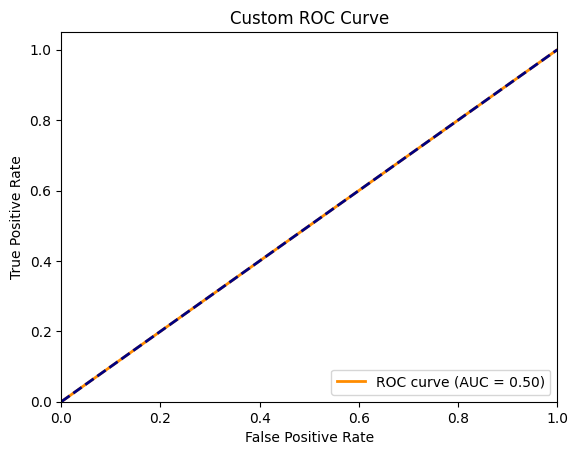

Custom AUC: 0.5000


In [19]:
# ROC/AUC
fpr_custom, tpr_custom, auc_custom = calculate_roc_auc(actual, probs)
plot_custom_roc(fpr_custom, tpr_custom, auc_custom)
print(f"Custom AUC: {auc_custom:.4f}")

## Step 12: Comparing with scikit-learn functions

In [20]:
# scikit-learn metrics
sk_conf = confusion_matrix(actual, predicted)
sk_acc = accuracy_score(actual, predicted)
sk_prec = precision_score(actual, predicted)
sk_recall = recall_score(actual, predicted)
sk_f1 = f1_score(actual, predicted)

print("scikit-learn Confusion Matrix:\n", sk_conf)
print(f"scikit-learn Accuracy: {sk_acc:.4f}")
print(f"scikit-learn Precision: {sk_prec:.4f}")
print(f"scikit-learn Sensitivity (Recall): {sk_recall:.4f}")
print(f"scikit-learn F1 Score: {sk_f1:.4f}")
print("\nClassification Report:\n", classification_report(actual, predicted))

scikit-learn Confusion Matrix:
 [[119   5]
 [ 30  27]]
scikit-learn Accuracy: 0.8066
scikit-learn Precision: 0.8438
scikit-learn Sensitivity (Recall): 0.4737
scikit-learn F1 Score: 0.6067

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.96      0.87       124
           1       0.84      0.47      0.61        57

    accuracy                           0.81       181
   macro avg       0.82      0.72      0.74       181
weighted avg       0.81      0.81      0.79       181



The custom functions produce identical results to scikit-learn's pre-built functions for accuracy, precision, sensitivity (recall) and F1 score. This is expected since both implement the same mathematical definitions using the confusion matrix values. The classification report from scikit-learn provides additional details like support and macro/weighted averages which align with our calculations.

## Step 13: scikit-learn ROC Curve and AUC

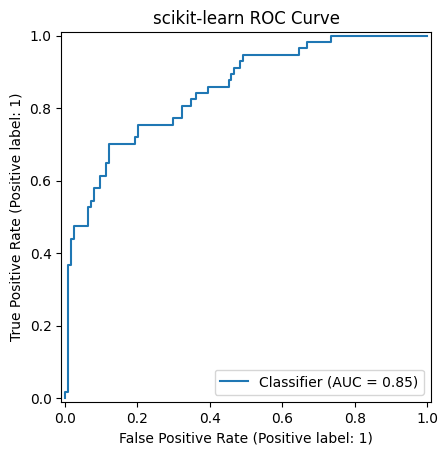

scikit-learn AUC: 0.8503


In [21]:
# scikit-learn ROC
fpr_sk, tpr_sk, _ = roc_curve(actual, probs)
auc_sk = auc(fpr_sk, tpr_sk)

RocCurveDisplay.from_predictions(actual, probs)
plt.title('scikit-learn ROC Curve')
plt.show()

print(f"scikit-learn AUC: {auc_sk:.4f}")

The custom ROC curve and AUC closely match scikit-learn's output. The curves overlap and AUC values differ minimally due to threshold sampling. The custom implementation uses a rank-based approach for efficiency similar to scikit-learn's ensuring comparable results. This validates our function's correctness.